# ECE 57000 Assignment 07 Exercise

Your Name:

For this assignment, you will do an ablation study on the DCGAN model discussed in class and implemented WGAN with weight clipping and (optional) WGAN with gradient penalty.

## Exercise 1: Ablation Study on DCGAN
An [ablation study](https://en.wikipedia.org/wiki/Ablation_(artificial_intelligence) measures performance changes after changing certain components in the AI system. The goal is to understand the contribution on each component for the overall system.

### Task 1.0 Original DCGAN on MNIST from class note

Here is the copy of the code implementation from [course website](https://www.davidinouye.com/course/ece57000-fall-2021/lectures/dcgan-mnist-edit.pdf). Please run the code to obtain the result and **use it as a baseline to compare the results** with the following the ablation tasks. 

#### Hyper-parameter and Dataloader setup

Random Seed:  999


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



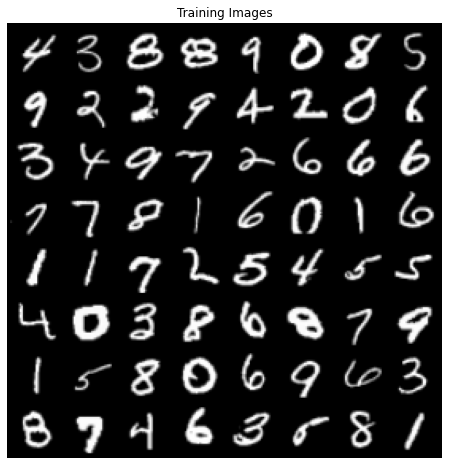

In [3]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmarks = False
os.environ['PYTHONHASHSEED'] = str(manualSeed)

# Root directory for dataset
# dataroot = "data/celeba"

# Number of workers for dataloader
workers = 1

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
#image_size = 64
image_size = 32

# Number of channels in the training images. For color images this is 3
#nc = 3
nc = 1 

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
#ngf = 64
ngf = 8

# Size of feature maps in discriminator
#ndf = 64
ndf = 8

# Number of training epochs
num_epochs = 5
num_epochs_wgan = 15
num_iters = 250

# Learning rate for optimizers
lr = 0.0002
lr_rms = 5e-4

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Several useful functions
def initialize_net(net_class, init_method, device, ngpu):

    # Create the generator
    net_inst = net_class(ngpu).to(device)

    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (ngpu > 1):
        net_inst = nn.DataParallel(net_inst, list(range(ngpu)))

    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.2.
    if init_method is not None:
        net_inst.apply(init_method)

    # Print the model
    print(net_inst)

    return net_inst

def plot_GAN_loss(losses, labels):

    plt.figure(figsize=(10,5))
    plt.title("Losses During Training")

    for loss, label in zip(losses, labels):
        plt.plot(loss,label=f"{label}")

    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def plot_real_fake_images(real_batch, fake_batch):

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(fake_batch[-1],(1,2,0)))
    plt.show()


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Download the MNIST dataset
dataset = dset.MNIST(
    'data', train=True, download=True,
   transform=transforms.Compose([
       transforms.Resize(image_size), # Resize from 28 x 28 to 32 x 32 (so power of 2)
       transforms.CenterCrop(image_size),
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
   ])) 

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

#### Architectural design for generator and discriminator

In [4]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution, state size. nz x 1 x 1
            nn.ConvTranspose2d( nz, ngf * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True), # inplace ReLU
            # current state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # current state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # current state size. ngf x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            # current state size. nc x 32 x 32 
            # Produce number between -1 and 1, as pixel values have been normalized to be between -1 and 1
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32 
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8 
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            # state size. (ndf*4) x 1 x 1
            nn.Sigmoid()  # Produce probability
        )

    def forward(self, input):
        return self.main(input)


#### Loss function and Training function

In [5]:
# Initialize networks
netG = initialize_net(Generator, weights_init, device, ngpu)
netD = initialize_net(Discriminator, weights_init, device, ngpu)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2,

#### Visualization of the results

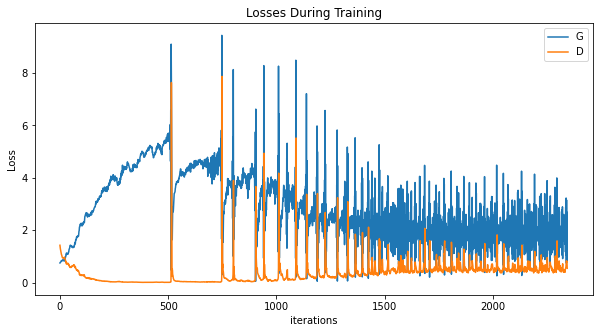

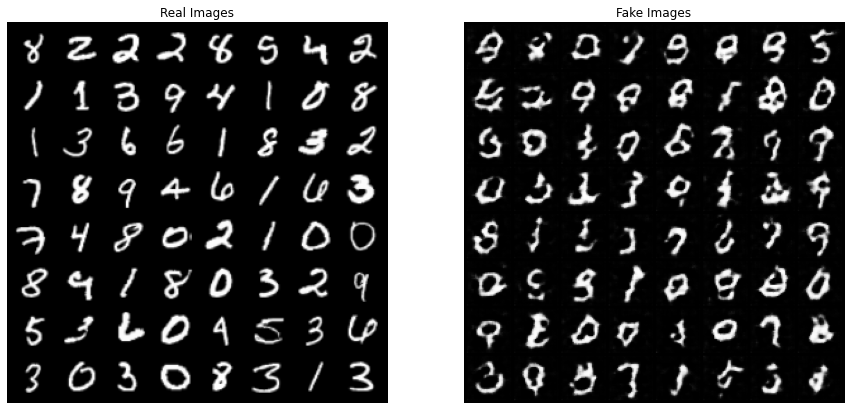

In [6]:
# plot the loss for generator and discriminator
plot_GAN_loss([G_losses, D_losses], ["G", "D"])

# Grab a batch of real images from the dataloader
plot_real_fake_images(next(iter(dataloader)), img_list)

### Task 1.1 Ablation study on batch normalization 

1. Please modify the code provided in the Task 1.0 so that the neural network architure does not contain any batch normalization layer.  
Hint: modify the ***Architectural design for generator and discriminator*** section in Task 1.0
2. Train the model with modified networks and visualize the results.

In [ ]:
# Generator Code
class Generator_woBN(nn.Module):
    def __init__(self, ngpu):
        super(Generator_woBN, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            ################################ YOUR CODE ################################
            # input is Z, going into a convolution, state size. nz x 1 x 1
            nn.ConvTranspose2d( nz, ngf * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.ReLU(True), # inplace ReLU
            # current state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.ReLU(True),
            # current state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.ReLU(True),
            # current state size. ngf x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            # current state size. nc x 32 x 32 
            # Produce number between -1 and 1, as pixel values have been normalized to be between -1 and 1
            nn.Tanh()
            ############################# END YOUR CODE ##############################
        )

    def forward(self, input):
        return self.main(input)


class Discriminator_woBN(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator_woBN, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            ################################ YOUR CODE ################################
            # input is (nc) x 32 x 32 
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8 
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            # state size. (ndf*4) x 1 x 1
            nn.Sigmoid()  # Produce probability
            ############################# END YOUR CODE ##############################
        )

    def forward(self, input):
        return self.main(input)

netG_noBN = initialize_net(Generator_woBN, weights_init, device, ngpu)
netD_noBN = initialize_net(Discriminator_woBN, weights_init, device, ngpu)

Generator_woBN(
  (main): Sequential(
    (0): ConvTranspose2d(100, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)
Discriminator_woBN(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(32, 1, kernel_s

In [ ]:
# Setup Adam optimizers for both G and D
optimizerD_noBN = optim.Adam(netD_noBN.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG_noBN = optim.Adam(netG_noBN.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD_noBN.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD_noBN(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG_noBN(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD_noBN(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD_noBN.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG_noBN.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD_noBN(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG_noBN.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG_noBN(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.3862	Loss_G: 0.6931	D(x): 0.5001	D(G(z)): 0.5000 / 0.5000
[0/5][50/469]	Loss_D: 1.1976	Loss_G: 0.4642	D(x): 0.8302	D(G(z)): 0.6357 / 0.6288
[0/5][100/469]	Loss_D: 0.7972	Loss_G: 0.9996	D(x): 0.7325	D(G(z)): 0.3822 / 0.3685
[0/5][150/469]	Loss_D: 0.7559	Loss_G: 0.6848	D(x): 0.9519	D(G(z)): 0.5033 / 0.5045
[0/5][200/469]	Loss_D: 1.0108	Loss_G: 0.5188	D(x): 0.9226	D(G(z)): 0.6011 / 0.5956
[0/5][250/469]	Loss_D: 1.2289	Loss_G: 0.4870	D(x): 0.7763	D(G(z)): 0.6164 / 0.6148
[0/5][300/469]	Loss_D: 0.9639	Loss_G: 0.6903	D(x): 0.7830	D(G(z)): 0.4989 / 0.5016
[0/5][350/469]	Loss_D: 0.6822	Loss_G: 0.8239	D(x): 0.9121	D(G(z)): 0.4393 / 0.4392
[0/5][400/469]	Loss_D: 0.6619	Loss_G: 0.7564	D(x): 0.9734	D(G(z)): 0.4693 / 0.4696
[0/5][450/469]	Loss_D: 0.6948	Loss_G: 0.7068	D(x): 0.9863	D(G(z)): 0.4936 / 0.4933
[1/5][0/469]	Loss_D: 0.7295	Loss_G: 0.6743	D(x): 0.9864	D(G(z)): 0.5108 / 0.5096
[1/5][50/469]	Loss_D: 0.7139	Loss_G: 0.7044	D(x): 0.9720	D(G(z)): 

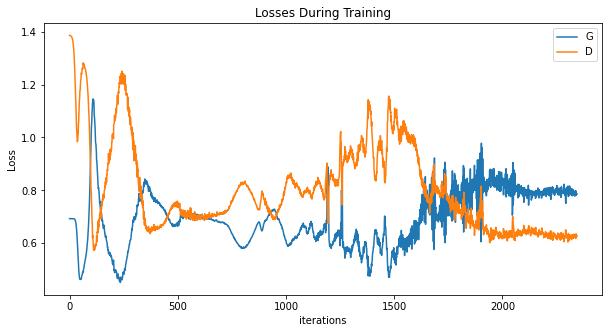

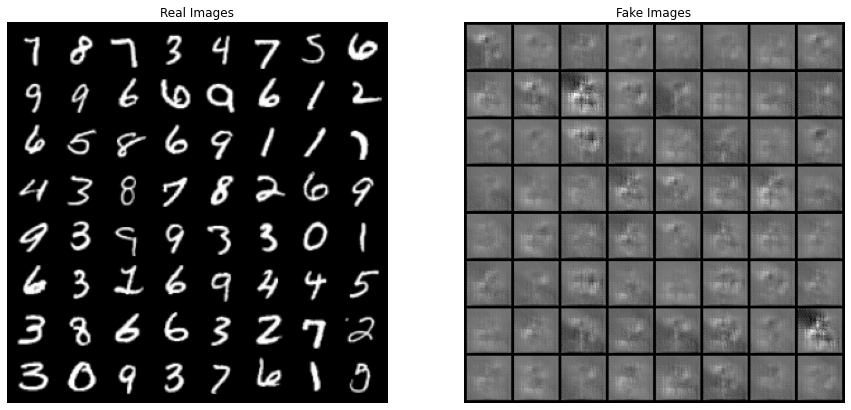

In [ ]:
# plot the loss for generator and discriminator
plot_GAN_loss([G_losses, D_losses], ["G", "D"])

# Grab a batch of real images from the dataloader
plot_real_fake_images(next(iter(dataloader)), img_list)

### Task 1.2 Ablation study on the trick: "Construct different mini-batches for real and fake"

1. Please modify the code provided in the Task 1.0 so that the discriminator algorithm part computes the forward and backward pass for fake and real images concatenated together (with their corresponding fake and real labels concatenated as well) instead of computing the forward and backward passes for fake and real images separately.  
Hint: modify the ***Loss function and Training function*** section in Task 1.0.
2. Train the model with modified networks and visualize the results.

In [4]:
# re-initilizate networks for the generator and discrimintor.
netG = initialize_net(Generator, weights_init, device, ngpu)
netD = initialize_net(Discriminator, weights_init, device, ngpu)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        ################################ YOUR CODE ################################

        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        real_labels = torch.full((b_size,), real_label, device=device)
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        fake_labels = torch.full((b_size,), fake_label, device=device)
        # joint input and label
        joint_input = torch.cat((real_cpu, fake.detach()), dim=0)
        joint_label = torch.cat((real_labels, fake_labels), dim=0)

        output = netD(joint_input).view(-1)
        errD = criterion(output, joint_label)
        errD.backward()
 
        # Update D
        optimizerD.step()

        ############################ END YOUR CODE ##############################

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label = torch.full((b_size,), real_label, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(G(z)): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2,

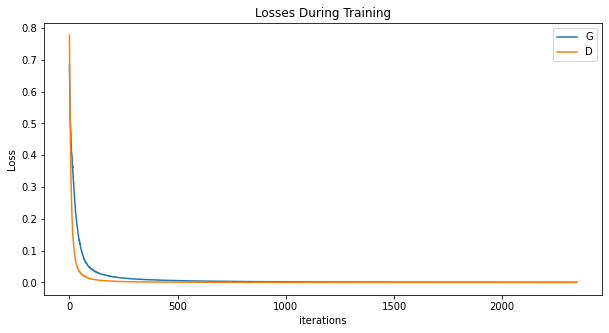

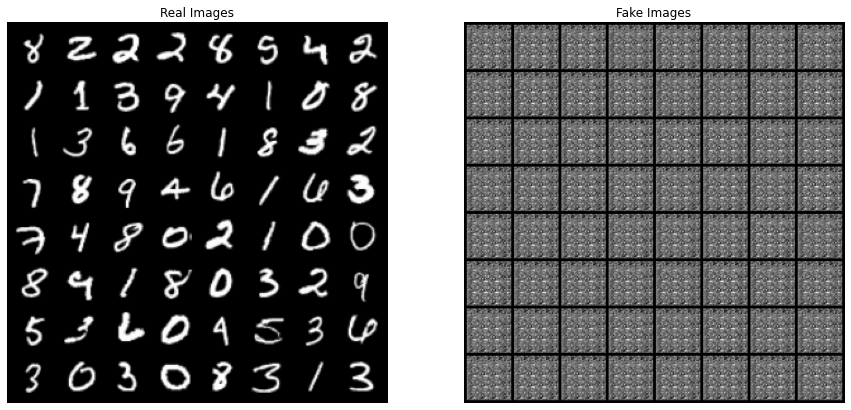

In [5]:
# plot the loss for generator and discriminator
plot_GAN_loss([G_losses, D_losses], ["G", "D"])

# Grab a batch of real images from the dataloader
plot_real_fake_images(next(iter(dataloader)), img_list)

### Task 1.3 Ablation study on the generator's loss function

1. Please modify the code provided in the Task 1.0 so that the *Generator* algorithm part minimizes $\log(1-D(G(z)))$ instead of the modified loss function suggested in the original GAN paper of $-\log(D(G(z)))$.
    1. Modify the ***Loss function and Training function*** section in Task 1.0 
    2. (Hint) Try to understand the definition of [BCE loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) first and how the modified loss function was implemented.
2. Train the model with modified networks and visualize the results.

In [11]:
# re-initilizate networks for the generator and discrimintor.
netG = initialize_net(Generator, weights_init, device, ngpu)
netD = initialize_net(Discriminator, weights_init, device, ngpu)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################

        ################################ YOUR CODE ################################

        netG.zero_grad()
        label = torch.full((b_size,), fake_label, device=device) 
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = -criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        ############################ END YOUR CODE ##############################

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2,

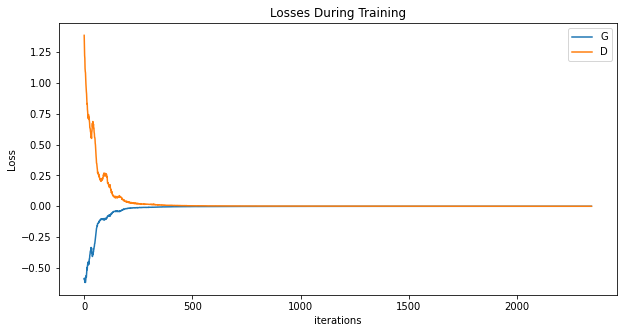

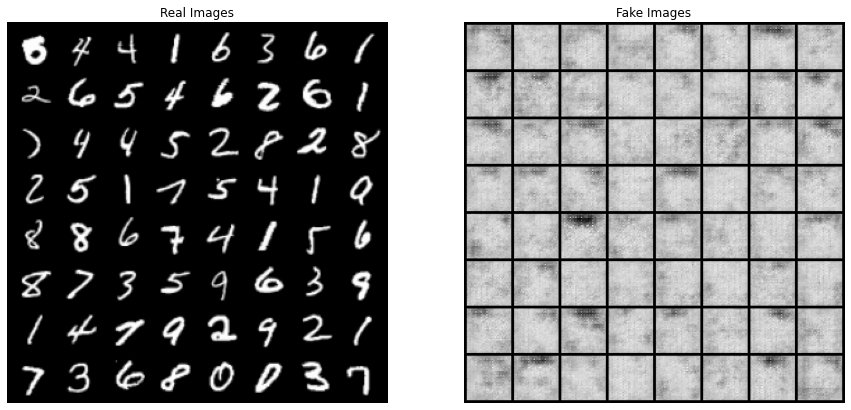

In [12]:
# plot the loss for generator and discriminator
plot_GAN_loss([G_losses, D_losses], ["G", "D"])

# Grab a batch of real images from the dataloader
plot_real_fake_images(next(iter(dataloader)), img_list)

### Task 1.4 Ablation study on the weight initialization

1. Please use the function `initialize_net` provided in Task 1.0 to initialize the generator and discriminator function without weight initialization (HINT: There is no need to modify the code for `initialize_net` function).
2. Train the model with modified networks and visualize the results.

In [13]:
################################ YOUR CODE ################################
netG_woinit = initialize_net(Generator, None, device, ngpu)
netD_woinit = initialize_net(Discriminator, None, device, ngpu)
###########################  END YOUR CODE ###############################

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2,

In [14]:
# Setup Adam optimizers for both G and D
optimizerD_woinit = optim.Adam(netD_woinit.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG_woinit = optim.Adam(netG_woinit.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD_woinit.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD_woinit(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG_woinit(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD_woinit(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD_woinit.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG_woinit.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD_woinit(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG_woinit.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG_woinit(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.5341	Loss_G: 0.6070	D(x): 0.5133	D(G(z)): 0.5672 / 0.5511
[0/5][50/469]	Loss_D: 0.4714	Loss_G: 1.3828	D(x): 0.8718	D(G(z)): 0.2798 / 0.2578
[0/5][100/469]	Loss_D: 0.4305	Loss_G: 1.6328	D(x): 0.8640	D(G(z)): 0.2412 / 0.2055
[0/5][150/469]	Loss_D: 0.3329	Loss_G: 2.0503	D(x): 0.8778	D(G(z)): 0.1760 / 0.1387
[0/5][200/469]	Loss_D: 0.2796	Loss_G: 2.3264	D(x): 0.8800	D(G(z)): 0.1298 / 0.1059
[0/5][250/469]	Loss_D: 0.1900	Loss_G: 2.5977	D(x): 0.9299	D(G(z)): 0.1068 / 0.0808
[0/5][300/469]	Loss_D: 0.1778	Loss_G: 2.7849	D(x): 0.9230	D(G(z)): 0.0887 / 0.0708
[0/5][350/469]	Loss_D: 0.1754	Loss_G: 2.8082	D(x): 0.9393	D(G(z)): 0.1022 / 0.0694
[0/5][400/469]	Loss_D: 0.1284	Loss_G: 3.4634	D(x): 0.9285	D(G(z)): 0.0496 / 0.0365
[0/5][450/469]	Loss_D: 0.1608	Loss_G: 3.1561	D(x): 0.8987	D(G(z)): 0.0454 / 0.0500
[1/5][0/469]	Loss_D: 0.1741	Loss_G: 4.1976	D(x): 0.9677	D(G(z)): 0.1286 / 0.0190
[1/5][50/469]	Loss_D: 0.1740	Loss_G: 3.8680	D(x): 0.9576	D(G(z)): 

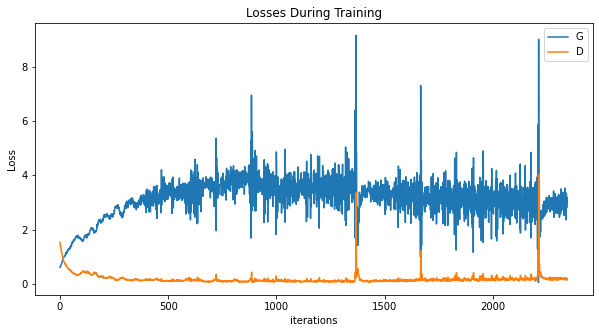

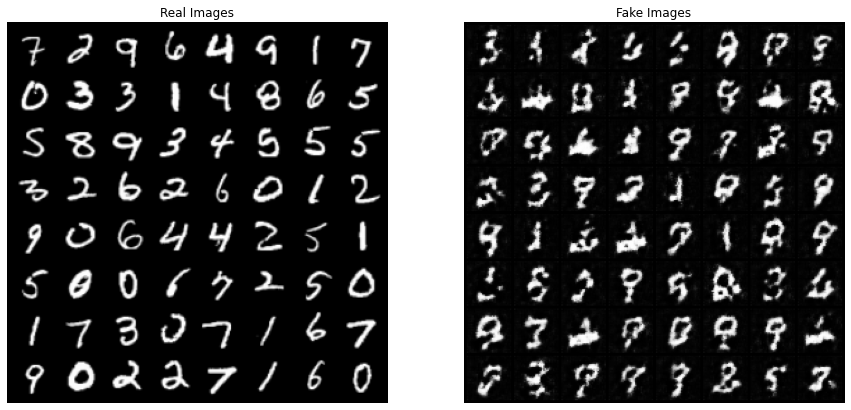

In [15]:
# plot the loss for generator and discriminator
plot_GAN_loss([G_losses, D_losses], ["G", "D"])

# Grab a batch of real images from the dataloader
plot_real_fake_images(next(iter(dataloader)), img_list)

## Exercise 2: Implement the WGAN with weight clipping
Wasserstein GAN ([WGAN](https://arxiv.org/abs/1701.07875)) is an alternative training strategy to traditional GAN. WGAN may provide more stable learning and may avoid problems faced in traditional GAN training like mode collapse. 

1. Rewrite the loss functions and training function according to the algorithm introduced in slide 18 in [Lecture note for WGAN](https://www.davidinouye.com/course/ece57000-fall-2021/lectures/wasserstein-gan.pdf). A few notes/hints:
    1. Keep the same generator as in Exercise 1, Task 1.0, but modify the discriminator so that there is no restriction on the range of the output. (Simply comment out the last `Sigmoid` layer)
    2. Modify the optimizer to be the RMSProp optimizer with a learning rate equal to the value in `lr_rms` (which we set to `5e-4`, which is larger than the rate in the paper but works better for our purposes).
    3. Use [`torch.Tensor.clamp_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.clamp_.html) function to clip the parameter values. You will need to do this for all parameters of the discriminator. See algorithm for when to do this.
2. Train the model with modified networks and visualize the results.

In [16]:
class Discriminator_WGAN(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator_WGAN, self).__init__()
        self.ngpu = ngpu
        ################################ YOUR CODE ################################
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32 
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8 
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            # state size. (ndf*4) x 1 x 1
        )

        ########################### END YOUR CODE ################################

    def forward(self, input):
        return self.main(input)

netG = initialize_net(Generator, weights_init, device, ngpu)
netD = initialize_net(Discriminator_WGAN, weights_init, device, ngpu)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator_WGAN(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), strid

In [17]:
############################ YOUR CODE ############################
# Setup RMSprop optimizers for both netG and netD with given learning rate as `lr_rms`
optimizerD = optim.RMSprop(netD.parameters(), lr=lr_rms)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr_rms)

######################## # END YOUR CODE ##########################

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
n_critic = 5
c = 0.01
dataloader_iter = iter(dataloader)

print("Starting Training Loop...")
num_iters = 1000

for iters in range(num_iters):
    
    ###########################################################################
    # (1) Train Discriminator more: minimize -(mean(D(real))-mean(D(fake)))
    ###########################################################################

    for p in netD.parameters():
        p.requires_grad = True

    for idx_critic in range(n_critic):

        netD.zero_grad()

        try:
            data = next(dataloader_iter)
        except StopIteration:
            dataloader_iter = iter(dataloader)
            data = next(dataloader_iter)

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        D_real = netD(real_cpu).view(-1)

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        D_fake = netD(fake).view(-1)
        
        ############################ YOUR CODE ############################
        # Define your loss function for variable `D_loss`
        D_loss = -torch.mean(D_real) + torch.mean(D_fake)

        # Backpropagate the loss function and upate the optimizer
        D_loss.backward()
        optimizerD.step()

        # Clip the gradient with limit `c` by using `clamp_()` function
        for p in netD.parameters():
          p.data.clamp_(-c, c)

        ######################## # END YOUR CODE ##########################

    ###########################################################################
    # (2) Update G network: minimize -mean(D(fake)) (Update only once in 5 epochs)
    ###########################################################################
    for p in netD.parameters():
        p.requires_grad = False
    
    netG.zero_grad()

    noise = torch.randn(b_size, nz, 1, 1, device=device)
    fake = netG(noise)
    D_fake = netD(fake).view(-1)

    ################################ YOUR CODE ################################
    # Define your loss function for variable `G_loss`
    G_loss = -torch.mean(D_fake)
    # Backpropagate the loss function and upate the optimizer
    G_loss.backward()
    optimizerG.step()
    ############################# END YOUR CODE ##############################

    # Output training stats
    if iters % 10 == 0:
        print('[%4d/%4d]   Loss_D: %6.4f    Loss_G: %6.4f'
            % (iters, num_iters, D_loss.item(), G_loss.item()))
    
    # Save Losses for plotting later
    G_losses.append(G_loss.item())
    D_losses.append(D_loss.item())
    
    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 100 == 0):
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

Starting Training Loop...
[   0/1000]   Loss_D: -0.0010    Loss_G: -0.0002
[  10/1000]   Loss_D: -0.0020    Loss_G: -0.0020
[  20/1000]   Loss_D: -0.0023    Loss_G: -0.0009
[  30/1000]   Loss_D: -0.0027    Loss_G: -0.0010
[  40/1000]   Loss_D: -0.0032    Loss_G: -0.0022
[  50/1000]   Loss_D: -0.0043    Loss_G: -0.0017
[  60/1000]   Loss_D: -0.0052    Loss_G: -0.0009
[  70/1000]   Loss_D: -0.0069    Loss_G: 0.0036
[  80/1000]   Loss_D: -0.0076    Loss_G: 0.0032
[  90/1000]   Loss_D: -0.0070    Loss_G: 0.0068
[ 100/1000]   Loss_D: -0.0090    Loss_G: 0.0038
[ 110/1000]   Loss_D: -0.0087    Loss_G: 0.0075
[ 120/1000]   Loss_D: -0.0092    Loss_G: 0.0061
[ 130/1000]   Loss_D: -0.0074    Loss_G: 0.0052
[ 140/1000]   Loss_D: -0.0079    Loss_G: -0.0010
[ 150/1000]   Loss_D: -0.0076    Loss_G: 0.0041
[ 160/1000]   Loss_D: -0.0067    Loss_G: 0.0006
[ 170/1000]   Loss_D: -0.0065    Loss_G: -0.0018
[ 180/1000]   Loss_D: -0.0061    Loss_G: -0.0028
[ 190/1000]   Loss_D: -0.0056    Loss_G: -0.0005
[ 2

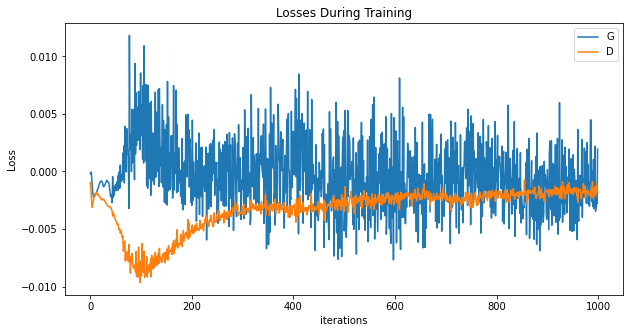

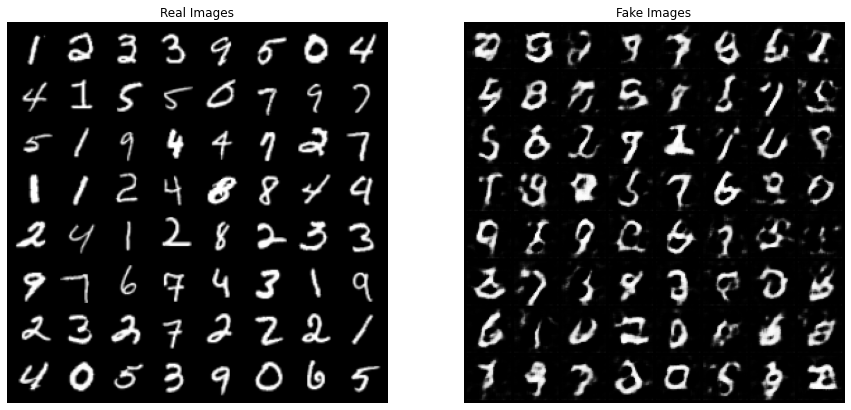

In [18]:
# plot the loss for generator and discriminator
plot_GAN_loss([G_losses, D_losses], ["G", "D"])

# Grab a batch of real images from the dataloader
plot_real_fake_images(next(iter(dataloader)), img_list)

## (Optional and ungraded) Exercise 3: Implement the WGAN with Gradient Penalty
1. Use slide 20 in [Lecture note for WGAN](https://www.davidinouye.com/course/ece57000-fall-2021/lectures/wasserstein-gan.pdf) to implement WGAN-GP algorithm. 
    1. Use the same discriminator and generator as in Exercise 2.
    2. Use Adam optimizer for WGAN-GP.
    3. If implemented correctly, we have setup some hyperparameters (different than the original algorithm) that seem to work in this situation.
    4. For calculating the gradient penalty term, you will need to:
        1. Create a batch of interpolated samples.
        2. Pass this interpolated batch through the discriminator.
        3. Compute the gradient of the discriminator with respect to the samples using [`torch.autograd.grad`](https://pytorch.org/docs/stable/generated/torch.autograd.grad.html). You will need to set:
            1. `outputs`
            2. `inputs`
            3. `grad_outputs`
            4. `create_graph=True` and `retain_graph=True` (because we want to backprop through this gradient calculation for the final objective.)
            5. Hint: Also make sure to understand the return result of this function to extract the gradients as necessary.
        4. Compute the gradient penalty (Hint: For numerical stability, we found that `grad_norm = torch.sqrt((grad**2).sum(1) + 1e-14)` is a simple way to compute the norm.) 
        5. Use $\lambda=10$ for the gradient penalty as in the original paper.
    
3. Train the model with modified networks and visualize the results.

In [ ]:
# Setup networks for WGAN-GP
netG = initialize_net(Generator, weights_init, device, ngpu)
netD = initialize_net(Discriminator_WGAN, weights_init, device, ngpu)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=5e-4, betas=(0.5, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=5e-4, betas=(0.5, 0.9))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
n_critic = 5
dataloader_iter = iter(dataloader)

print("Starting Training Loop...")
num_iters = 1000

for iters in range(num_iters):
    
    ###########################################################################
    # (1) Train Discriminator more: minimize -(mean(D(real))-mean(D(fake)))+GP
    ###########################################################################

    for p in netD.parameters():
        p.requires_grad = True

    for idx_critic in range(n_critic):

        netD.zero_grad()

        try:
            data = next(dataloader_iter)
        except StopIteration:
            dataloader_iter = iter(dataloader)

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        D_real = netD(real_cpu).view(-1)

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        D_fake = netD(fake).view(-1)
        
        ############################ YOUR CODE ############################
        # Compute the gradient penalty term

        # Define your loss function for variable `D_loss`

        # Backpropagate the loss function and upate the optimizer


        ######################## # END YOUR CODE ##########################

    ###########################################################################
    # (2) Update G network: minimize -mean(D(fake)) (Update only once in 5 epochs)
    ###########################################################################
    for p in netD.parameters():
        p.requires_grad = False
    
    netG.zero_grad()

    noise = torch.randn(b_size, nz, 1, 1, device=device)
    fake = netG(noise)
    D_fake = netD(fake).view(-1)

    ################################ YOUR CODE ################################
    # Define your loss function for variable `G_loss`

    # Backpropagate the loss function and upate the optimizer

    ############################# END YOUR CODE ##############################

    # Output training stats
    if iters % 10 == 0:
        print('[%4d/%4d]   Loss_D: %6.4f    Loss_G: %6.4f'
            % (iters, num_iters, D_loss.item(), G_loss.item()))
    
    # Save Losses for plotting later
    G_losses.append(G_loss.item())
    D_losses.append(D_loss.item())
    
    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 100 == 0):
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

In [ ]:
# plot the loss for generator and discriminator
plot_GAN_loss([G_losses, D_losses], ["G", "D"])

# Grab a batch of real images from the dataloader
plot_real_fake_images(next(iter(dataloader)), img_list)